In [13]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')

from volatility import MIDAS
from weights import Beta
from base import BaseModel
from helper_functions import create_matrix
import pandas as pd
import numpy as np
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Mixed Data Sampling Simulation

The simulation was inspired from [Conrad and Kleen (2019)] research paper. <br>
Suppose we have $X_t$ is an AR(1) process, that:
$$X_{i,t} = \phi X_{i-1, t} + \epsilon_t$$
where t = 1, ...,T, i = 1, ...,$I_t$, $I_t$ equals to 22. $\phi = 0.9$ and $\epsilon_t \sim \mathcal{N}(0, 1)$ standard normal variable, than the MIDAS equation will be:
$$y_t = m + \theta \sum_{k=0}^K \xi_k (1, w) X_{i-k, t} + z_t$$
with the parameters m = 0.1, $\theta = 0.3$ and w = 4.0. To see how accurate our code about to estimate the theoratical parameters, we run Monte Carlo simulation with three sample size (T), namely 100, 200, 400. It comes out, that with very small sample size it can estimate parameters accurately.

In [3]:
class MIDAS_sim(BaseModel):
    def __init__(self, lag = 22, plot = True, *args):
        self.lag = lag
        self.plot = plot
        self.args = args
        
    def initialize_params(self, X):
        self.init_params = np.linspace(1, 1, 3)
        return self.init_params
    
    def model_filter(self, params, X, y):
        if isinstance(y, int) or isinstance(y, float):
            T = y
        else:
            T = len(y)
        model = np.zeros(T)
        
        for i in range(T):
            model[i] = params[0] + params[1] * Beta().x_weighted(X[i * self.lag : (i + 1) * self.lag].reshape((1, self.lag)), [1.0, params[2]])
        
        return model
    
    def loglikelihood(self, params, X, y):
        return np.sum((y - self.model_filter(params, X, y)) ** 2)
    

    def simulate(self, params = [0.1, 0.3, 4.0], num = 500, K = 22):
        X = np.zeros(num * K)
        y = np.zeros(num)
        
        for i in range(num * K):
            if i == 0:
                X[i] = np.random.normal()
            else:
                X[i] = 0.9 * X[i - 1] + np.random.normal()
                
        for i in range(num):
            y[i] = params[0] + params[1] * Beta().x_weighted(X[i * K : (i + 1) * K].reshape((1, K)), [1.0, params[2]]) + np.random.normal(scale = 0.7**2)
        
        return X, y  
    
    def create_sims(self, number_of_sims = 500, length = 500, K = 22, params = [0.1, 0.3, 4.0]):
        lls, b0, b1, th, runtime = np.zeros(number_of_sims), np.zeros(number_of_sims), np.zeros(number_of_sims), np.zeros(number_of_sims), np.zeros(number_of_sims)
        
        for i in range(number_of_sims):
            np.random.seed(i)
            X, y = self.simulate(params = params, num = length, K = K)
            start = time.time()
            self.fit(['pos', 'pos', 'pos'], X, y)
            runtime[i] = time.time() - start
            lls[i] = self.opt.fun
            b0[i], b1[i], th[i] = self.optimized_params[0], self.optimized_params[1], self.optimized_params[2]
            
        return pd.DataFrame(data = {'LogLike': lls, 
                                    'Beta0': b0, 
                                    'Beta1': b1, 
                                    'Theta':th})
    def forecasting(self, X, k = 10):
        X_n = np.zeros(k * 22)
        
        for i in range(k * 22):
            if i == 0:
                X_n[i] = 0.9 * X[-1] + np.random.normal()
            else:
                X_n[i] = 0.9 * X_n[i - 1] + np.random.normal()
                
        try:
            y_hat = self.model_filter(self.optimized_params, X_n, k)
        except:
            params = input('Please give the parameters:')
            
        return X_n, y_hat

In [10]:
sim100 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/midas_sim100.csv')
sim200 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/midas_sim200.csv')
sim500 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/midas_sim500.csv')
sim1000 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/midas_sim1000.csv')
sim2000 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/midas_sim2000.csv')

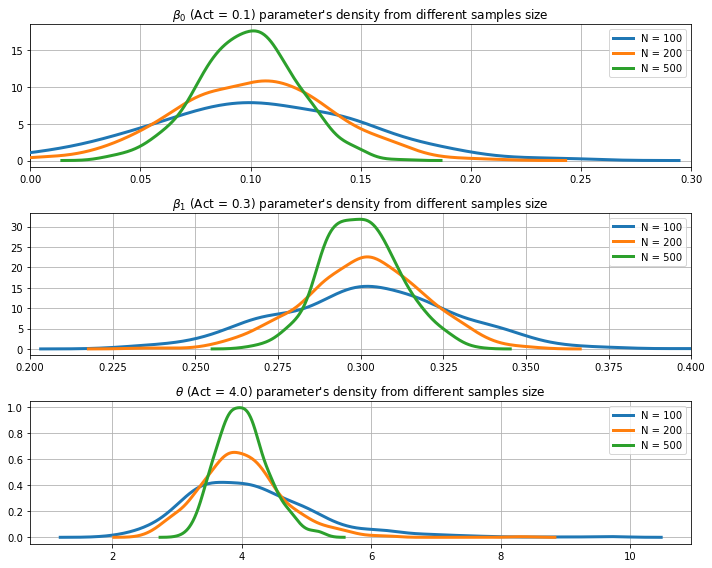

In [16]:
beta0_100 = sm.nonparametric.KDEUnivariate(sim100.iloc[:, 2].values)
beta0_100.fit()
beta0_200 = sm.nonparametric.KDEUnivariate(sim200.iloc[:, 2].values)
beta0_200.fit()
beta0_500 = sm.nonparametric.KDEUnivariate(sim500.iloc[:, 2].values)
beta0_500.fit()
beta0_1000 = sm.nonparametric.KDEUnivariate(sim1000.iloc[:, 2].values)
beta0_1000.fit()
beta0_2000 = sm.nonparametric.KDEUnivariate(sim2000.iloc[:, 2].values)
beta0_2000.fit()

beta1_100 = sm.nonparametric.KDEUnivariate(sim100.iloc[:, 3].values)
beta1_100.fit()
beta1_200 = sm.nonparametric.KDEUnivariate(sim200.iloc[:, 3].values)
beta1_200.fit()
beta1_500 = sm.nonparametric.KDEUnivariate(sim500.iloc[:, 3].values)
beta1_500.fit()
beta1_1000 = sm.nonparametric.KDEUnivariate(sim1000.iloc[:, 3].values)
beta1_1000.fit()
beta1_2000 = sm.nonparametric.KDEUnivariate(sim2000.iloc[:, 3].values)
beta1_2000.fit()

theta_100 = sm.nonparametric.KDEUnivariate(sim100.iloc[:, 4].values)
theta_100.fit()
theta_200 = sm.nonparametric.KDEUnivariate(sim200.iloc[:, 4].values)
theta_200.fit()
theta_500 = sm.nonparametric.KDEUnivariate(sim500.iloc[:, 4].values)
theta_500.fit()
theta_1000 = sm.nonparametric.KDEUnivariate(sim1000.iloc[:, 4].values)
theta_1000.fit()
theta_2000 = sm.nonparametric.KDEUnivariate(sim2000.iloc[:, 4].values)
theta_2000.fit()

fig , ax = plt.subplots(3, 1, figsize=(10, 8), tight_layout=True)

ax[0].plot(beta0_100.support, beta0_100.density, lw = 3, label = 'N = 100', zorder = 10)
ax[0].plot(beta0_200.support, beta0_200.density, lw = 3, label = 'N = 200', zorder = 10)
ax[0].plot(beta0_500.support, beta0_500.density, lw = 3, label = 'N = 500', zorder = 10)
ax[0].plot(beta0_1000.support, beta0_1000.density, lw = 3, label = 'N = 1000', zorder = 10)
ax[0].plot(beta0_2000.support, beta0_2000.density, lw = 3, label = 'N = 2000', zorder = 10)
ax[0].set_title(r'$\beta_0$'+" (Act = 0.1) parameter's density from different samples size")
ax[0].grid(True, zorder = -5)
ax[0].set_xlim((0.0, 0.3))
ax[0].legend(loc = 'best')

ax[1].plot(beta1_100.support, beta1_100.density, lw = 3, label = 'N = 100', zorder = 10)
ax[1].plot(beta1_200.support, beta1_200.density, lw = 3, label = 'N = 200', zorder = 10)
ax[1].plot(beta1_500.support, beta1_500.density, lw = 3, label = 'N = 500', zorder = 10)
ax[1].plot(beta1_1000.support, beta1_1000.density, lw = 3, label = 'N = 1000', zorder = 10)
ax[1].plot(beta1_2000.support, beta1_2000.density, lw = 3, label = 'N = 2000', zorder = 10)
ax[1].set_title(r'$\beta_1$'+" (Act = 0.3) parameter's density from different samples size")
ax[1].grid(True, zorder = -5)
ax[1].set_xlim((0.2, 0.4))
ax[1].legend(loc = 'best')

ax[2].plot(theta_100.support, theta_100.density, lw = 3, label = 'N = 100', zorder = 10)
ax[2].plot(theta_200.support, theta_200.density, lw = 3, label = 'N = 200', zorder = 10)
ax[2].plot(theta_500.support, theta_500.density, lw = 3, label = 'N = 500', zorder = 10)
ax[2].plot(theta_1000.support, theta_1000.density, lw = 3, label = 'N = 1000', zorder = 10)
ax[2].plot(theta_2000.support, theta_2000.density, lw = 3, label = 'N = 2000', zorder = 10)
ax[2].set_title(r'$\theta$'+" (Act = 4.0) parameter's density from different samples size")
ax[2].grid(True, zorder = -5)
#ax[2].set_xlim((0.0, 1.0))
ax[2].legend(loc = 'best')

plt.show()

In [17]:
def bias_2(actual_value, list_of_est, lags):
    """
    Function for calculating the Squared Bias
    
    Bias^2 = \sum_{j=0}^N (\hat{w_j} - w_j)^2
    
    where \hat{w_j} is the estimated weight and w_j is the actual weight.

    Parameters
    ----------
    actual_value : int or flaot
        Theoretical value for the Beta lag function
    list_of_est : array or value
        Contain the estimated parameter for the Beta lag function
    lags : int or flaot
        The number of lags

    Returns
    -------
    bias : array or value
        Contain the squared bias

    """
    bias = np.zeros(len(list_of_est))
    
    act = Beta().weights([1.0, actual_value], lags)
    
    for i in range(len(list_of_est)):
        w = Beta().weights([1.0, list_of_est[i]], lags)
        bias[i] = np.sum( (w - act) ** 2 )
    
    return bias

In [24]:
bs100 = bias_2(4.0, sim100.iloc[:, 4], 22)
bs200 = bias_2(4.0, sim200.iloc[:, 4], 22)
bs500 = bias_2(4.0, sim500.iloc[:, 4], 22)
bs1000 = bias_2(4.0, sim1000.iloc[:, 4], 22)
bs2000 = bias_2(4.0, sim2000.iloc[:, 4], 22)

In [26]:
pd.DataFrame(data = {'SquaredBias': [np.mean(bs100), np.mean(bs200), np.mean(bs500), np.mean(bs1000), np.mean(bs2000)], 
                     'Std': [np.std(bs100), np.std(bs200), np.std(bs500), np.std(bs1000), np.std(bs2000)]}, 
             index = [100, 200, 500, 1000, 2000])

,SquaredBias,Std
100,0.003153,0.005857
200,0.001399,0.002501
500,0.000490,0.000683
